In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [21]:
USE_LARGER_RESUTLS = False

IGNORE_SMALLER_LIST = ('baseline.csv', 'dino.csv', 'flipping.csv')
IGNORE_LARGER_LIST = ('baseline_larger_dataset.csv', 'dino_larger_dataset.csv', 'flipping_larger_dataset.csv')
CORRECT_KEY = 'containment_high_containment_cos'
INCORRECT_KEYS = ['containment_behind_cos', 'containment_support_cos']
ORDERED_COLUMNS = ['model', 'training', 'flip', 'dino', 'image_index', 'bowl_color', 'target_object', 
        'containment_high_containment_cos', 'containment_behind_cos', 'containment_support_cos',
        'high_containment_behind_cos', 'high_containment_support_cos', 'behind_support_cos', 
        'correct', 'cos_ratio', 'cos_diff']
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'Robot', 'RubberDuck', 'Teddy', 'Truck']


def load_and_join_dataframes(folder: str, ext: str = '.csv', ignore_list: typing.Sequence[str] = tuple()) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def add_target_object_field(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(target_object=[TARGET_OBJECTS[i % len(TARGET_OBJECTS)] for i in df.image_index])


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    correct = []
    cos_ratio = []
    cos_diff = []

    for _, row in df.iterrows():    
        correct_val = row[correct_key]
        max_incorrect_val = max([row[k] for k in incorrect_keys])  # type: ignore

        correct.append(correct_val >= max_incorrect_val)
        cos_ratio.append(correct_val / max_incorrect_val)
        cos_diff.append(correct_val - max_incorrect_val)

    return df.assign(correct=correct, cos_ratio=cos_ratio, cos_diff=cos_diff)


def full_load_pipeline(folder: str, ignore_list: typing.Sequence[str] = tuple()):
    df = load_and_join_dataframes(folder, ignore_list=ignore_list)
    df.drop(columns=[df.columns[0]], inplace=True)  # type: ignore
    df = parse_model_name(df)
    df = df.rename(columns={'index': 'image_index'})
    df = add_target_object_field(df)
    df = evaluate_accuracy(df)
    df = df[ORDERED_COLUMNS]
    return df


larger_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_SMALLER_LIST)
smaller_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_LARGER_LIST)
print(larger_df.shape, smaller_df.shape)

if USE_LARGER_RESUTLS:
    combined_df = larger_df
else:
    combined_df = smaller_df


print(combined_df.shape)
combined_df.head()

(98304, 16) (12288, 16)
(12288, 16)


,model,training,flip,dino,image_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
0,resnext,saycam(S)-flip,s,None,0,brown,BeachBall,0.821403,0.827495,0.846809,0.928499,0.909522,0.974116,False,0.969998,-0.025406
1,resnext,saycam(S)-flip,s,None,1,blue,Knight,0.856041,0.829619,0.841452,0.944829,0.912327,0.954147,True,1.017338,0.014589
2,resnext,saycam(S)-flip,s,None,2,purple,Lego,0.838563,0.838034,0.814633,0.952457,0.899645,0.939837,True,1.000631,0.000529
3,resnext,saycam(S)-flip,s,None,3,green,Pineapple,0.817329,0.808149,0.797166,0.935150,0.886878,0.955024,True,1.011358,0.009179
4,resnext,saycam(S)-flip,s,None,4,brown,Robot,0.828670,0.791044,0.763196,0.904463,0.852929,0.949094,True,1.047565,0.037626


In [5]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'acc_mean',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy',
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df[plot_field].mean()

    if compute_std:
        std = grouped_df[plot_field].std()
        if sem:
            std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
    
    else:
        if sem:
            std = grouped_df.acc_sem.mean()
        else:
            std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        for i, panel_value in enumerate(orders_by_field[panel_by]):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, mean[panel_value], std[panel_value],
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, 
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_rows == 0 else '')

            else:
                plot_single_panel(panel_ax, mean[panel_value], std[panel_value], 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_rows == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            title = f'{panel_by} = {panel_value}'
            if panel_titles is not None:
                title = panel_titles[i]
                
            panel_ax.set_title(title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [27]:
def compare_df_group_and_filter(first_df: pd.DataFrame, second_df: pd.DataFrame,
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    relevant_fields: typing.Optional[typing.Sequence[str]] = None,
):
    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    first_grouped_df = filter_and_group(first_df, filter_dict, group_by_fields)
    first_mean = first_grouped_df.mean()

    second_grouped_df = filter_and_group(second_df, filter_dict, group_by_fields)
    second_mean = second_grouped_df.mean()

    if relevant_fields is None:
        return first_mean - second_mean

    relevant_fields = list(relevant_fields)
    return first_mean[relevant_fields] - second_mean[relevant_fields]

    

In [28]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

containment_high_containment_cos   correct     cos_ratio
training  model                                                              
ImageNet  mobilenet                      6.584840e-05  0.000000  3.672985e-04
          resnext                       -9.573124e-05 -0.002197 -1.095968e-05
random    mobilenet                     -4.617237e-07 -0.500000 -5.699037e-02
          resnext                       -2.115550e-06 -0.119263 -2.965217e-07
saycam(S) mobilenet                     -3.922676e-04  0.002075  5.563265e-06
          resnext                       -1.038521e-03 -0.003174  1.420848e-04

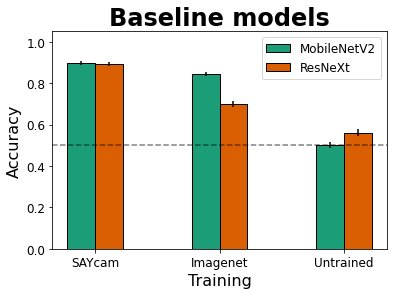

In [8]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

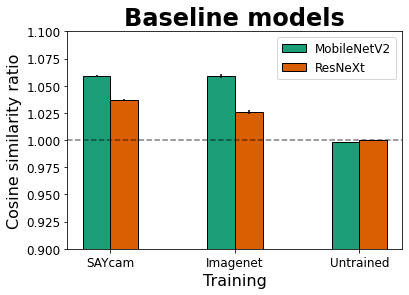

In [9]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    ylabel='Cosine similarity ratio',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

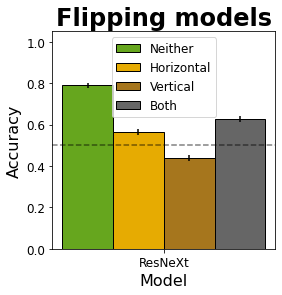

In [10]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

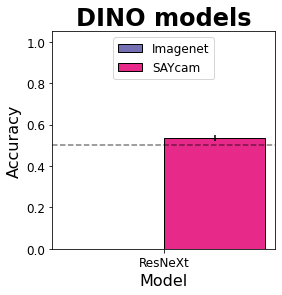

In [11]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

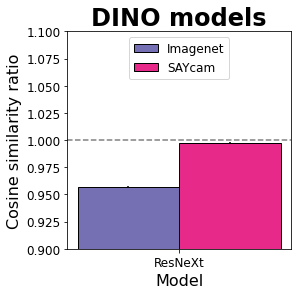

In [12]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    ylabel='Cosine similarity ratio',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [13]:
filter_and_group(combined_df, dict(training='DINO'), ['model', 'dino']).correct.mean()

model    dino     
resnext  ImageNet     0.00000
         saycam(S)    0.53418
Name: correct, dtype: float64

In [14]:
combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_96338/3096591689.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']


,model,training,flip,dino,image_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
11264,resnext,DINO,None,ImageNet,0,brown,BeachBall,0.839141,0.875026,0.881289,0.948535,0.945324,0.967396,False,0.952174,-0.042149
11265,resnext,DINO,None,ImageNet,1,blue,Knight,0.884040,0.877565,0.898226,0.957285,0.927317,0.949506,False,0.984207,-0.014186
11266,resnext,DINO,None,ImageNet,2,purple,Lego,0.807176,0.862019,0.840312,0.930387,0.904878,0.941243,False,0.936378,-0.054843
11267,resnext,DINO,None,ImageNet,3,green,Pineapple,0.849684,0.867118,0.884284,0.958636,0.912403,0.945931,False,0.960872,-0.034600
11268,resnext,DINO,None,ImageNet,4,brown,Robot,0.851729,0.868783,0.868985,0.934821,0.905083,0.944743,False,0.980142,-0.017256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12283,resnext,DINO,None,ImageNet,1019,green,Pineapple,0.836444,0.861583,0.873542,0.954927,0.905369,0.946470,False,0.957531,-0.037098
12284,resnext,DINO,None,ImageNet,1020,brown,Robot,0.839658,0.866353,0.863785,0.929928,0.903461,0.947949,False,0.969188,-0.026694
12285,resnext,DINO,None,ImageNet,1021,blue,RubberDuck,0.846208,0.879867,0.883563,0.945256,0.910593,0.961684,False,0.957722,-0.037355
12286,resnext,DINO,None,ImageNet,1022,purple,Teddy,0.824687,0.885994,0.863791,0.928199,0.881619,0.945410,False,0.930805,-0.061307


In [29]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

containment_high_containment_cos   correct     cos_ratio
bowl_color flip                                                          
blue       h                        -1.036678e-07  0.000000 -4.364053e-08
           hv                       -2.753222e-08  0.000000 -6.256327e-08
           s                        -7.139170e-08  0.000000 -7.017475e-08
           v                         3.085006e-08  0.000000  4.581636e-10
brown      h                        -8.046778e-04  0.005859 -5.554399e-04
           hv                       -1.112019e-03 -0.000977  1.213424e-03
           s                        -1.004535e-03  0.014160  8.670752e-04
           v                        -3.018705e-03  0.000000 -1.712855e-05
green      h                         0.000000e+00  0.000000  0.000000e+00
           hv                        0.000000e+00  0.000000  0.000000e+00
           s                         0.000000e+00  0.000000  0.000000e+00
           v                         0.000000e+00  0.000000  0.000000e+00
purple     h                        -1.775334e-09  0.000000 -4.608485e-09
           hv                       -5.704351e-09  0.000000  2.138426e-08
           s                         2.561137e-09  0.000000  8.741960e-10
           v                         6.548362e-09  0.000000  5.774464e-09

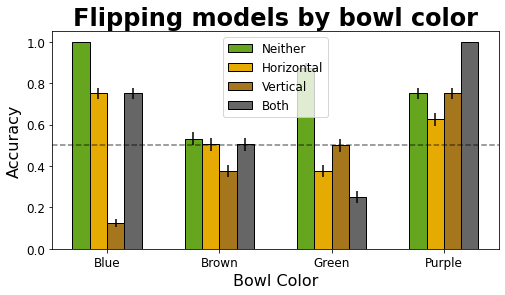

In [15]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

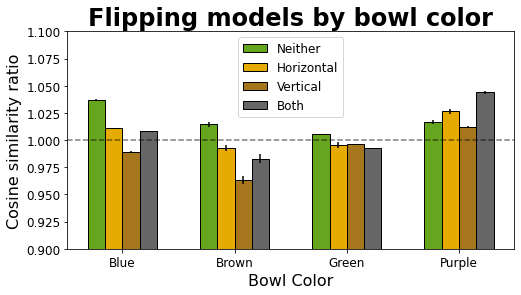

In [16]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    ylabel='Cosine similarity ratio',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

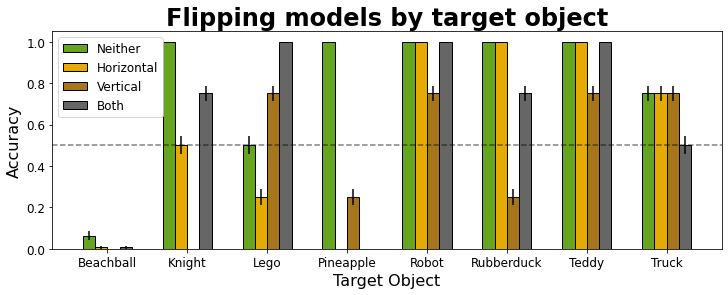

In [17]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

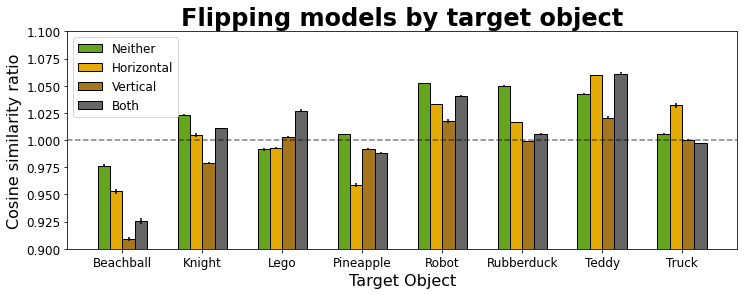

In [18]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylabel='Cosine similarity ratio',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

KeyError: ('BeachBall', 's')

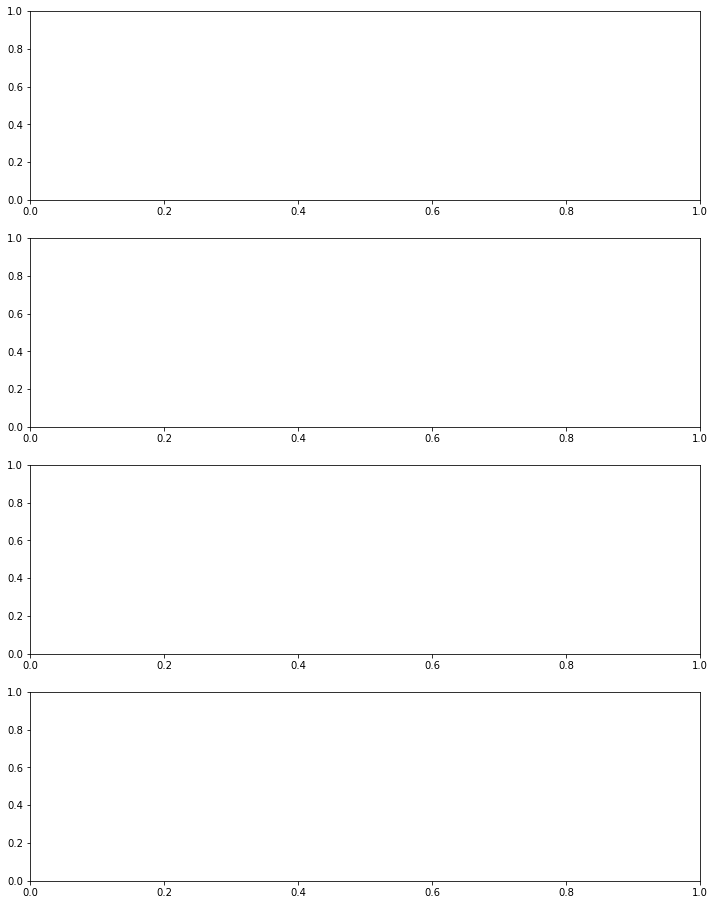

In [30]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [31]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

containment_high_containment_cos   correct  \
bowl_color target_object flip                                               
blue       Knight        h                        -2.182787e-07  0.000000   
                         hv                       -6.001210e-08  0.000000   
                         s                        -1.491280e-07  0.000000   
                         v                         5.890615e-08  0.000000   
           RubberDuck    h                         1.094304e-08  0.000000   
                         hv                        4.947651e-09  0.000000   
                         s                         6.344635e-09  0.000000   
                         v                         2.793968e-09  0.000000   
brown      BeachBall     h                        -1.609327e-03  0.011719   
                         hv                       -2.224088e-03 -0.001953   
                         s                        -2.009073e-03  0.028320   
                         v                        -6.037370e-03  0.000000   
           Robot         h                        -2.823072e-08  0.000000   
                         hv                        5.087350e-08  0.000000   
                         s                         3.841706e-09  0.000000   
                         v                        -4.016329e-08  0.000000   
green      Pineapple     h                         0.000000e+00  0.000000   
                         hv                        0.000000e+00  0.000000   
                         s                         0.000000e+00  0.000000   
                         v                         0.000000e+00  0.000000   
           Truck         h                         0.000000e+00  0.000000   
                         hv                        0.000000e+00  0.000000   
                         s                         0.000000e+00  0.000000   
                         v                         0.000000e+00  0.000000   
purple     Lego          h                         0.000000e+00  0.000000   
                         hv                        0.000000e+00  0.000000   
                         s                         0.000000e+00  0.000000   
                         v                         0.000000e+00  0.000000   
           Teddy         h                        -3.550667e-09  0.000000   
                         hv                       -1.140870e-08  0.000000   
                         s                         5.122274e-09  0.000000   
                         v                         1.309672e-08  0.000000   

                                  cos_ratio  
bowl_color target_object flip                
blue       Knight        h     4.083164e-08  
                         hv   -3.405076e-08  
                         s    -1.428452e-07  
                         v    -2.835400e-08  
           RubberDuck    h    -1.281127e-07  
                         hv   -9.107578e-08  
                         s     2.495643e-09  
                         v     2.927032e-08  
brown      BeachBall     h    -1.110850e-03  
                         hv    2.426764e-03  
                         s     1.734157e-03  
                         v    -3.408582e-05  
           Robot         h    -2.965026e-08  
                         hv    8.392836e-08  
                         s    -6.540917e-09  
                         v    -1.712770e-07  
green      Pineapple     h     0.000000e+00  
                         hv    0.000000e+00  
                         s     0.000000e+00  
                         v     0.000000e+00  
           Truck         h     0.000000e+00  
                         hv    0.000000e+00  
                         s     0.000000e+00  
                         v     0.000000e+00  
purple     Lego          h     0.000000e+00  
                         hv    0.000000e+00  
                         s     0.000000e+00  
                         v     0.000000e+00  
           Teddy         h    -9

In [33]:
for df in (smaller_df, larger_df):
    for bowl_color in df.bowl_color.unique():
        print(bowl_color, df[df.bowl_color == bowl_color].image_index.unique())

brown [   0    4    8   12   16   20   24   28   32   36   40   44   48   52
   56   60   64   68   72   76   80   84   88   92   96  100  104  108
  112  116  120  124  128  132  136  140  144  148  152  156  160  164
  168  172  176  180  184  188  192  196  200  204  208  212  216  220
  224  228  232  236  240  244  248  252  256  260  264  268  272  276
  280  284  288  292  296  300  304  308  312  316  320  324  328  332
  336  340  344  348  352  356  360  364  368  372  376  380  384  388
  392  396  400  404  408  412  416  420  424  428  432  436  440  444
  448  452  456  460  464  468  472  476  480  484  488  492  496  500
  504  508  512  516  520  524  528  532  536  540  544  548  552  556
  560  564  568  572  576  580  584  588  592  596  600  604  608  612
  616  620  624  628  632  636  640  644  648  652  656  660  664  668
  672  676  680  684  688  692  696  700  704  708  712  716  720  724
  728  732  736  740  744  748  752  756  760  764  768  772  776  780


In [34]:
for df in (smaller_df, larger_df):
    for target_object in df.target_object.unique():
        print(target_object, df[df.target_object == target_object].image_index.unique())

BeachBall [   0    8   16   24   32   40   48   56   64   72   80   88   96  104
  112  120  128  136  144  152  160  168  176  184  192  200  208  216
  224  232  240  248  256  264  272  280  288  296  304  312  320  328
  336  344  352  360  368  376  384  392  400  408  416  424  432  440
  448  456  464  472  480  488  496  504  512  520  528  536  544  552
  560  568  576  584  592  600  608  616  624  632  640  648  656  664
  672  680  688  696  704  712  720  728  736  744  752  760  768  776
  784  792  800  808  816  824  832  840  848  856  864  872  880  888
  896  904  912  920  928  936  944  952  960  968  976  984  992 1000
 1008 1016]
Knight [   1    9   17   25   33   41   49   57   65   73   81   89   97  105
  113  121  129  137  145  153  161  169  177  185  193  201  209  217
  225  233  241  249  257  265  273  281  289  297  305  313  321  329
  337  345  353  361  369  377  385  393  401  409  417  425  433  441
  449  457  465  473  481  489  497  505  513  5